# GAN - Generative Adversial Networks

Composed of two networks: Discriminator and Generator.

Discriminator classify whether image is real or generated by the generator.
Generator generates images which should be so good to cheat discriminator

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# plotting MNIST image
def plot(image):
    plt.axis('off')
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.show()
    
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

# Print the shapes of images from each subset
print ("IMAGES:")
print (mnist.test.images.shape)
print (mnist.train.images.shape)
print (mnist.validation.images.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
IMAGES:
(10000, 784)
(55000, 784)
(5000, 784)


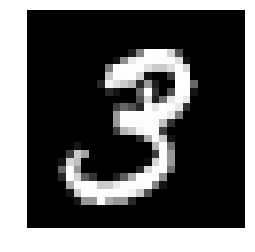

In [3]:
plot(mnist.train.images[1])

In [4]:
print(mnist.train.images[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [5]:
def get_weight_variable(shape):
    # normal distribution with mean = 0, standard deviation = 0.02
    init = tf.random_normal(shape, stddev=0.02)
    return tf.Variable(init)    

# Discriminator
1. First convolutional layer -> maps to one gray scale image to 16 feature maps
2. Second convolutional layer -> maps 16 features to 64 features maps
3. Third convolutional layer -> maps 64 features to 256 features maps
4. Fully connected layer -> maps 256 features into output layer with 2 classes (real and generated images)

Using stride in size 2 in width and height directions (divide images size by 4)

In [6]:
# matrix W and biased vector b used for first convolutional layer -> 16 filters, 5 x 5 x 1 size
d_W1 = get_weight_variable([5, 5, 1, 16])
d_b1 = get_weight_variable([16])

# matrix W and biased vector b used for second convolutional layer -> 64 filters, 5 x 5 x 16 size
d_W2 = get_weight_variable([5, 5, 16, 64])
d_b2 = get_weight_variable([64])

# matrix W and biased vector b used for third convolutional layer -> 256 filters, 5 x 5 x 64 size
d_W3 = get_weight_variable([5, 5, 64, 256])
d_b3 = get_weight_variable([256])

# matrix W and biased vector b used by th e output fully convolutional layer -> from 4096 features to 2 classes
d_W4 = get_weight_variable([4096, 1]) # from 4096 features to 1 feature
d_b4 = get_weight_variable([1])

In [7]:
def discriminator(x):
    # create first layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W1, [1, 2, 2, 1], padding='SAME') # [batch_size, 14, 14, 16]
    x = tf.nn.relu(x + d_b1)
    
    # create second layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W2, [1, 2, 2, 1], padding='SAME') # [batch_size, 7, 7, 64]
    x = tf.nn.relu(x + d_b2)
    
    # create third layer - use stride 2 in width/height, padding = 'SAME', activated by ReLU fun
    x = tf.nn.conv2d(x, d_W3, [1, 2, 2, 1], padding='SAME') # [batch_size, 4, 4, 256]
    x = tf.nn.relu(x + d_b3)
    
    # reshape input 4*4*256 = 4096 dimensions
    x = tf.reshape(x, [-1, 4*4*256])
    
    # create fully connected layer, multiply x by d_W4 and add bias, this will give logits to discriminator network
    D_logit = tf.matmul(x, d_W4) + d_b4 # from [b_size, 4096] to [b_size, 1]
    
    D_probability = tf.nn.sigmoid(D_logit)
    
    return D_probability, D_logit

# Generator
Create 28 x 28 image from 100D vector from normal distribution using transpoe convolution operation

1. Fully connected layer -> maps initial 100 dimensions into 4096 features (4x4 with 256 channels)
2. First transpose convolutional layer -> maps 4x4x256 images to 7x7 with 64 channels (4096 -> 3136)
3. Second transpose convolutionl layer -> maps 7x7x64 images to 14x14 with 16 channels
4. Third transpose convolutional layer -> maps 14x14x16 images to 28x28 with 1 channel (grayscale)

In [8]:
# matrix W and biased vector b used for input fully connected layer -> 100 random features into 4096D (4x4x256 image)
g_W1 = get_weight_variable([100, 4096])
g_b1 = get_weight_variable([4096])

# matrix W and biased vector b used for first transpose convolutional layer -> 64 transpose_conv filter with 5x5x256
g_W2 = get_weight_variable([5, 5, 64, 256])
g_b2 = get_weight_variable([64])

# matrix W and biased vector b used for input fully connected layer -> 16 transpose_conv filter with 5x5x64
g_W3 = get_weight_variable([5, 5, 16, 64])
g_b3 = get_weight_variable([16])

# matrix W and biased vector b used for input fully connected layer -> 1 transpose_conv filter with 5x5x16
g_W4 = get_weight_variable([5, 5, 1, 16])
g_b4 = get_weight_variable([1])

In [9]:
def generator(z):
    
    # fully-con layer [b_size, 100] -> [b_size, 4096]
    z = tf.matmul(z, g_W1) + g_b1
    z = tf.nn.relu(z)
    z = tf.nn.dropout(z, generator_prob_keeper)
    z = tf.reshape(z, [-1, 4, 4, 256]) # reshape [b_size, 4096] -> [b_size, 4, 4, 256]
    
    # first transpose convolutional layer
    # enlarge image 4x4x256 -> 7x7x64, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W2, [batch_size, 7, 7, 64], [1, 2, 2, 1], padding='SAME')
    z = tf.nn.relu(z + g_b2)
    z = tf.nn.dropout(z, generator_prob_keeper)
    
    # second transpose convolutional layer
    # enlarge image 7x7x64 -> 14x14x16, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W3, [batch_size, 14, 14, 16], [1, 2, 2, 1], padding='SAME')
    z = tf.nn.relu(z + g_b3)
    z = tf.nn.dropout(z, generator_prob_keeper)
    
    # third transpose convolutional layer
    # enlarge image 14x14x16 -> 28x28x1, use stride 2 width/height
    # apply convolution, ReLU and dropout with generator_prob_keeper probability
    z = tf.nn.conv2d_transpose(z, g_W4, [batch_size, 28, 28, 1], [1, 2, 2, 1], padding='SAME')
    
    G_probability = tf.nn.sigmoid(z + g_b4)
    
    return G_probability

In [10]:
def sampling_Z(m1, m2):
    return np.random.normal(size=[m1, m2], scale=1)

In [11]:
#Constants
batch_size = 64
Z_dimension = 100 # size of initialized vector (dimension)

# Discriminator
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

#Generator
Z = tf.placeholder(tf.float32, shape=[None, 100])
generator_prob_keeper = 0.9 #probability of dropout

In [12]:
Generator_sample = generator(Z)

D_real, D_logit_real = discriminator(X)

D_fake, D_logit_fake = discriminator(Generator_sample)

In [13]:
ep = 1e-5

D_loss_real = tf.reduce_mean(-tf.log(D_real + ep)) # loss on real examples

D_loss_fake = tf.reduce_mean(-tf.log(1 - D_fake + ep)) # loss on fake examples

D_loss = D_loss_real + D_loss_fake

# create AdamOptimizer to minimalize cross_entropy loss function
var_list_d = [d_W1, d_b1, d_W2, d_b2, d_W3, d_b3, d_W4, d_b4]

D_solver = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(D_loss, var_list=var_list_d)


In [ ]:
G_loss = tf.reduce_mean(-tf.log(D_fake + ep))

var_list_g = [g_W1, g_b1, g_W2, g_b2, g_W3, g_b3, g_W4, g_b4]

G_solver = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(G_loss, var_list=var_list_g)

1 Epoch: 0.0013333333333333333
G_loss: 0.0009581
D_loss: 0.001849


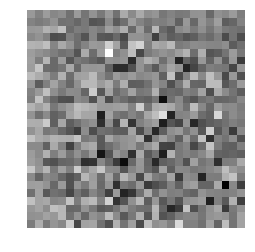

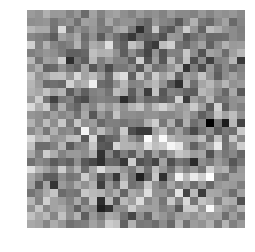

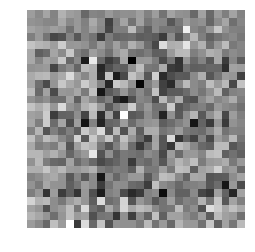

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

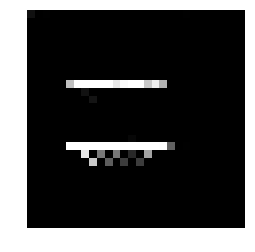

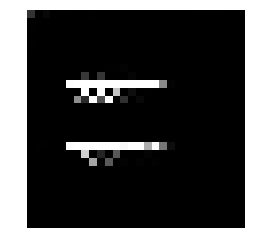

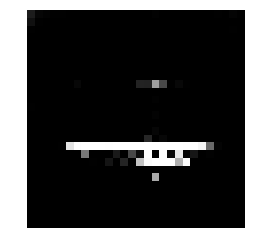

752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 100

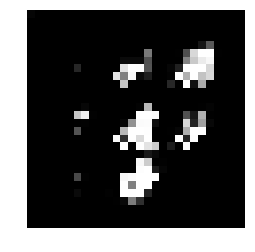

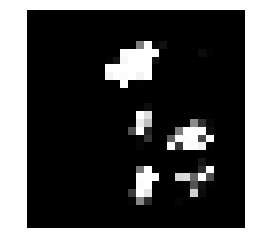

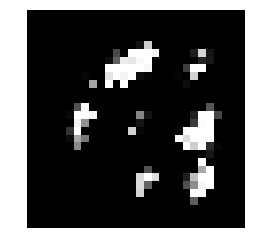

1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 

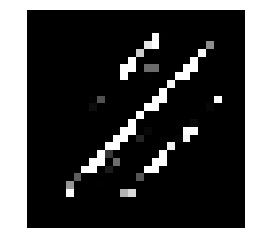

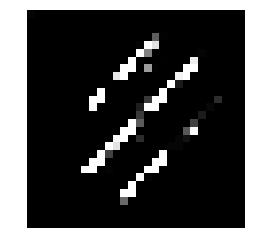

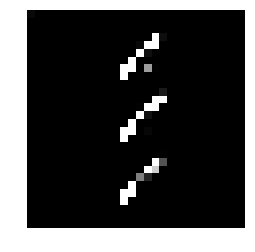

2252 2253 2254 2255 2256 2257 2258 2259 2260 2261 2262 2263 2264 2265 2266 2267 2268 2269 2270 2271 2272 2273 2274 2275 2276 2277 2278 2279 2280 2281 2282 2283 2284 2285 2286 2287 2288 2289 2290 2291 2292 2293 2294 2295 2296 2297 2298 2299 2300 2301 2302 2303 2304 2305 2306 2307 2308 2309 2310 2311 2312 2313 2314 2315 2316 2317 2318 2319 2320 2321 2322 2323 2324 2325 2326 2327 2328 2329 2330 2331 2332 2333 2334 2335 2336 2337 2338 2339 2340 2341 2342 2343 2344 2345 2346 2347 2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2410 2411 2412 2413 2414 2415 2416 2417 2418 2419 2420 2421 2422 2423 2424 2425 2426 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 2437 2438 2439 2440 2441 2442 2443 2444 2445 2446 2447 2448 2449 2450 2451 

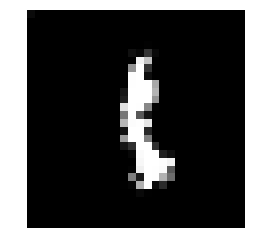

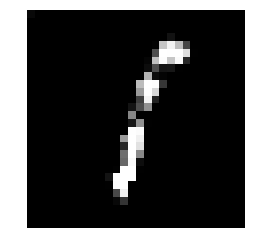

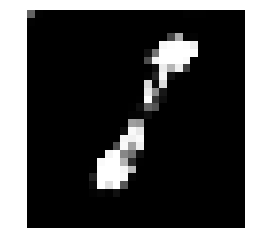

3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201 

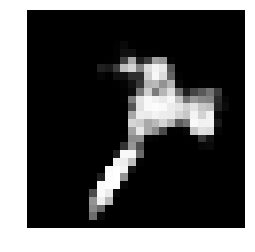

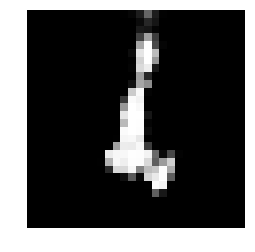

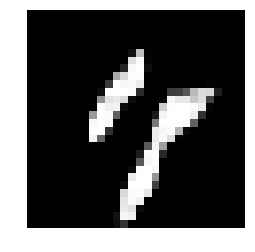

3752 3753 3754 3755 3756 3757 3758 3759 3760 3761 3762 3763 3764 3765 3766 3767 3768 3769 3770 3771 3772 3773 3774 3775 3776 3777 3778 3779 3780 3781 3782 3783 3784 3785 3786 3787 3788 3789 3790 3791 3792 3793 3794 3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 3805 3806 3807 3808 3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819 3820 3821 3822 3823 3824 3825 3826 3827 3828 3829 3830 3831 3832 3833 3834 3835 3836 3837 3838 3839 3840 3841 3842 3843 3844 3845 3846 3847 3848 3849 3850 3851 3852 3853 3854 3855 3856 3857 3858 3859 3860 3861 3862 3863 3864 3865 3866 3867 3868 3869 3870 3871 3872 3873 3874 3875 3876 3877 3878 3879 3880 3881 3882 3883 3884 3885 3886 3887 3888 3889 3890 3891 3892 3893 3894 3895 3896 3897 3898 3899 3900 3901 3902 3903 3904 3905 3906 3907 3908 3909 3910 3911 3912 3913 3914 3915 3916 3917 3918 3919 3920 3921 3922 3923 3924 3925 3926 3927 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939 3940 3941 3942 3943 3944 3945 3946 3947 3948 3949 3950 3951 

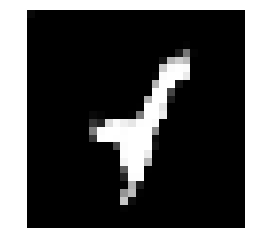

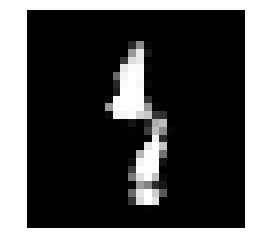

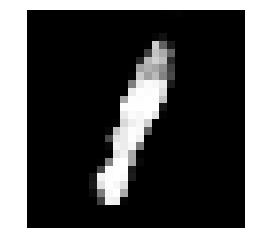

4502 4503 4504 4505 4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 4516 4517 4518 4519 4520 4521 4522 4523 4524 4525 4526 4527 4528 4529 4530 4531 4532 4533 4534 4535 4536 4537 4538 4539 4540 4541 4542 4543 4544 4545 4546 4547 4548 4549 4550 4551 4552 4553 4554 4555 4556 4557 4558 4559 4560 4561 4562 4563 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573 4574 4575 4576 4577 4578 4579 4580 4581 4582 4583 4584 4585 4586 4587 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615 4616 4617 4618 4619 4620 4621 4622 4623 4624 4625 4626 4627 4628 4629 4630 4631 4632 4633 4634 4635 4636 4637 4638 4639 4640 4641 4642 4643 4644 4645 4646 4647 4648 4649 4650 4651 4652 4653 4654 4655 4656 4657 4658 4659 4660 4661 4662 4663 4664 4665 4666 4667 4668 4669 4670 4671 4672 4673 4674 4675 4676 4677 4678 4679 4680 4681 4682 4683 4684 4685 4686 4687 4688 4689 4690 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700 4701 

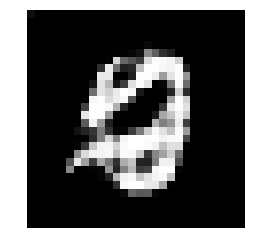

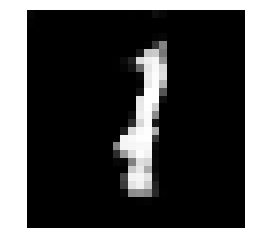

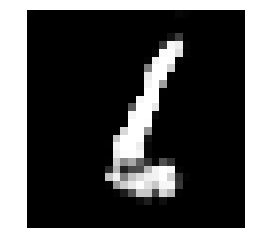

5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338 5339 5340 5341 5342 5343 5344 5345 5346 5347 5348 5349 5350 5351 5352 5353 5354 5355 5356 5357 5358 5359 5360 5361 5362 5363 5364 5365 5366 5367 5368 5369 5370 5371 5372 5373 5374 5375 5376 5377 5378 5379 5380 5381 5382 5383 5384 5385 5386 5387 5388 5389 5390 5391 5392 5393 5394 5395 5396 5397 5398 5399 5400 5401 5402 5403 5404 5405 5406 5407 5408 5409 5410 5411 5412 5413 5414 5415 5416 5417 5418 5419 5420 5421 5422 5423 5424 5425 5426 5427 5428 5429 5430 5431 5432 5433 5434 5435 5436 5437 5438 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5449 5450 5451 

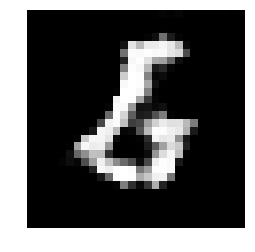

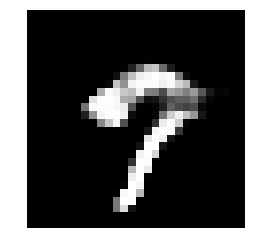

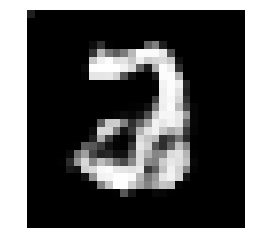

6002 6003 6004 6005 6006 6007 6008 6009 6010 6011 6012 6013 6014 6015 6016 6017 6018 6019 6020 6021 6022 6023 6024 6025 6026 6027 6028 6029 6030 6031 6032 6033 6034 6035 6036 6037 6038 6039 6040 6041 6042 6043 6044 6045 6046 6047 6048 6049 6050 6051 6052 6053 6054 6055 6056 6057 6058 6059 6060 6061 6062 6063 6064 6065 6066 6067 6068 6069 6070 6071 6072 6073 6074 6075 6076 6077 6078 6079 6080 6081 6082 6083 6084 6085 6086 6087 6088 6089 6090 6091 6092 6093 6094 6095 6096 6097 6098 6099 6100 6101 6102 6103 6104 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115 6116 6117 6118 6119 6120 6121 6122 6123 6124 6125 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136 6137 6138 6139 6140 6141 6142 6143 6144 6145 6146 6147 6148 6149 6150 6151 6152 6153 6154 6155 6156 6157 6158 6159 6160 6161 6162 6163 6164 6165 6166 6167 6168 6169 6170 6171 6172 6173 6174 6175 6176 6177 6178 6179 6180 6181 6182 6183 6184 6185 6186 6187 6188 6189 6190 6191 6192 6193 6194 6195 6196 6197 6198 6199 6200 6201 

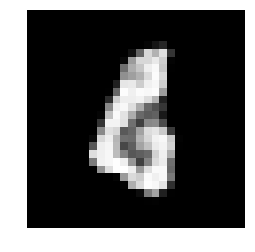

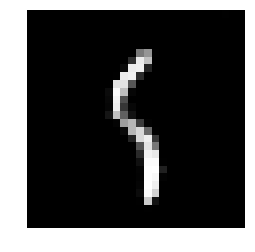

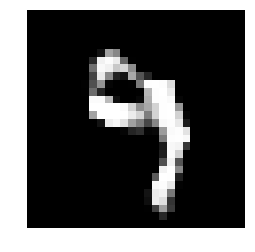

6752 6753 6754 6755 6756 6757 6758 6759 6760 6761 6762 6763 6764 6765 6766 6767 6768 6769 6770 6771 6772 6773 6774 6775 6776 6777 6778 6779 6780 6781 6782 6783 6784 6785 6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949 6950 6951 

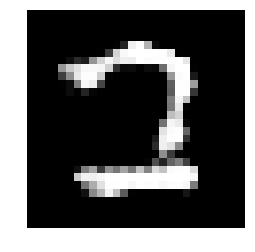

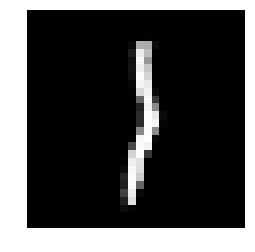

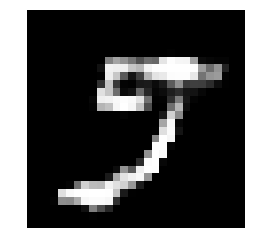

7502 7503 7504 7505 7506 7507 7508 7509 7510 7511 7512 7513 7514 7515 7516 7517 7518 7519 7520 7521 7522 7523 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534 7535 7536 7537 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548 7549 7550 7551 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562 7563 7564 7565 7566 7567 7568 7569 7570 7571 7572 7573 7574 7575 7576 7577 7578 7579 7580 7581 7582 7583 7584 7585 7586 7587 7588 7589 7590 7591 7592 7593 7594 7595 7596 7597 7598 7599 7600 7601 7602 7603 7604 7605 7606 7607 7608 7609 7610 7611 7612 7613 7614 7615 7616 7617 7618 7619 7620 7621 7622 7623 7624 7625 7626 7627 7628 7629 7630 7631 7632 7633 7634 7635 7636 7637 7638 7639 7640 7641 7642 7643 7644 7645 7646 7647 7648 7649 7650 7651 7652 7653 7654 7655 7656 7657 7658 7659 7660 7661 7662 7663 7664 7665 7666 7667 7668 7669 7670 7671 7672 7673 7674 7675 7676 7677 7678 7679 7680 7681 7682 7683 7684 7685 7686 7687 7688 7689 7690 7691 7692 7693 7694 7695 7696 7697 7698 7699 7700 7701 

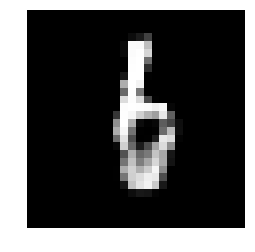

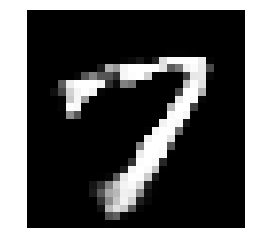

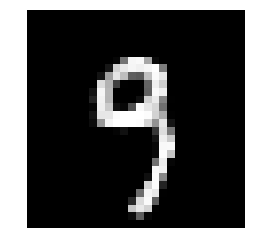

8252 8253 8254 8255 8256 8257 8258 8259 8260 8261 8262 8263 8264 8265 8266 8267 8268 8269 8270 8271 8272 8273 8274 8275 8276 8277 8278 8279 8280 8281 8282 8283 8284 8285 8286 8287 8288 8289 8290 8291 8292 8293 8294 8295 8296 8297 8298 8299 8300 8301 8302 8303 8304 8305 8306 8307 8308 8309 8310 8311 8312 8313 8314 8315 8316 8317 8318 8319 8320 8321 8322 8323 8324 8325 8326 8327 8328 8329 8330 8331 8332 8333 8334 8335 8336 8337 8338 8339 8340 8341 8342 8343 8344 8345 8346 8347 8348 8349 8350 8351 8352 8353 8354 8355 8356 8357 8358 8359 8360 8361 8362 8363 8364 8365 8366 8367 8368 8369 8370 8371 8372 8373 8374 8375 8376 8377 8378 8379 8380 8381 8382 8383 8384 8385 8386 8387 8388 8389 8390 8391 8392 8393 8394 8395 8396 8397 8398 8399 8400 8401 8402 8403 8404 8405 8406 8407 8408 8409 8410 8411 8412 8413 8414 8415 8416 8417 8418 8419 8420 8421 8422 8423 8424 8425 8426 8427 8428 8429 8430 8431 8432 8433 8434 8435 8436 8437 8438 8439 8440 8441 8442 8443 8444 8445 8446 8447 8448 8449 8450 8451 

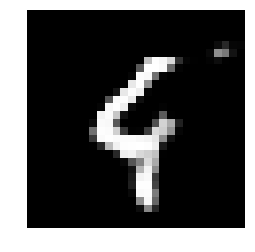

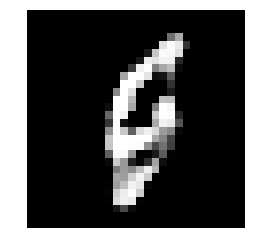

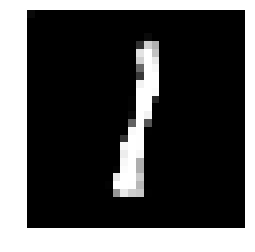

9002 9003 9004 9005 9006 9007 9008 9009 9010 9011 9012 9013 9014 9015 9016 9017 9018 9019 9020 9021 9022 9023 9024 9025 9026 9027 9028 9029 9030 9031 9032 9033 9034 9035 9036 9037 9038 9039 9040 9041 9042 9043 9044 9045 9046 9047 9048 9049 9050 9051 9052 9053 9054 9055 9056 9057 9058 9059 9060 9061 9062 9063 9064 9065 9066 9067 9068 9069 9070 9071 9072 9073 9074 9075 9076 9077 9078 9079 9080 9081 9082 9083 9084 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9095 9096 9097 9098 9099 9100 9101 9102 9103 9104 9105 9106 9107 9108 9109 9110 9111 9112 9113 9114 9115 9116 9117 9118 9119 9120 9121 9122 9123 9124 9125 9126 9127 9128 9129 9130 9131 9132 9133 9134 9135 9136 9137 9138 9139 9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153 9154 9155 9156 9157 9158 9159 9160 9161 9162 9163 9164 9165 9166 9167 9168 9169 9170 9171 9172 9173 9174 9175 9176 9177 9178 9179 9180 9181 9182 9183 9184 9185 9186 9187 9188 9189 9190 9191 9192 9193 9194 9195 9196 9197 9198 9199 9200 9201 

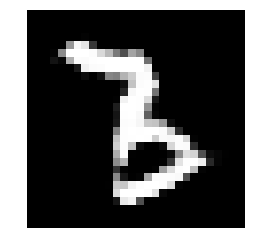

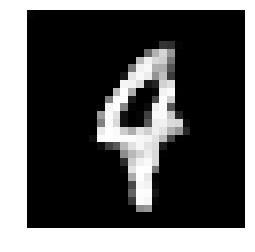

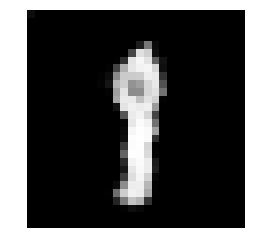

9752 9753 9754 9755 9756 9757 9758 9759 9760 9761 9762 9763 9764 9765 9766 9767 9768 9769 9770 9771 9772 9773 9774 9775 9776 9777 9778 9779 9780 9781 9782 9783 9784 9785 9786 9787 9788 9789 9790 9791 9792 9793 9794 9795 9796 9797 9798 9799 9800 9801 9802 9803 9804 9805 9806 9807 9808 9809 9810 9811 9812 9813 9814 9815 9816 9817 9818 9819 9820 9821 9822 9823 9824 9825 9826 9827 9828 9829 9830 9831 9832 9833 9834 9835 9836 9837 9838 9839 9840 9841 9842 9843 9844 9845 9846 9847 9848 9849 9850 9851 9852 9853 9854 9855 9856 9857 9858 9859 9860 9861 9862 9863 9864 9865 9866 9867 9868 9869 9870 9871 9872 9873 9874 9875 9876 9877 9878 9879 9880 9881 9882 9883 9884 9885 9886 9887 9888 9889 9890 9891 9892 9893 9894 9895 9896 9897 9898 9899 9900 9901 9902 9903 9904 9905 9906 9907 9908 9909 9910 9911 9912 9913 9914 9915 9916 9917 9918 9919 9920 9921 9922 9923 9924 9925 9926 9927 9928 9929 9930 9931 9932 9933 9934 9935 9936 9937 9938 9939 9940 9941 9942 9943 9944 9945 9946 9947 9948 9949 9950 9951 

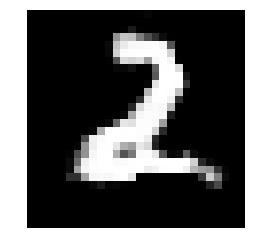

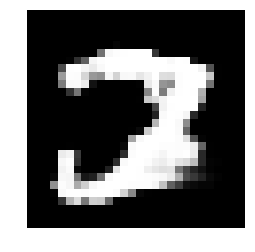

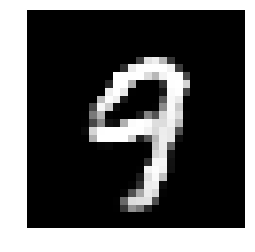

10502 10503 10504 10505 10506 10507 10508 10509 10510 10511 10512 10513 10514 10515 10516 10517 10518 10519 10520 10521 10522 10523 10524 10525 10526 10527 10528 10529 10530 10531 10532 10533 10534 10535 10536 10537 10538 10539 10540 10541 10542 10543 10544 10545 10546 10547 10548 10549 10550 10551 10552 10553 10554 10555 10556 10557 10558 10559 10560 10561 10562 10563 10564 10565 10566 10567 10568 10569 10570 10571 10572 10573 10574 10575 10576 10577 10578 10579 10580 10581 10582 10583 10584 10585 10586 10587 10588 10589 10590 10591 10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663 10664 10665 10666 10667 1066

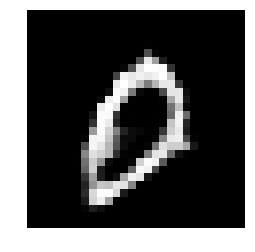

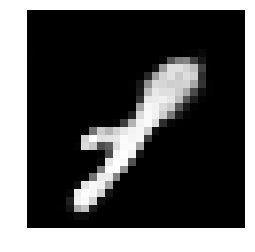

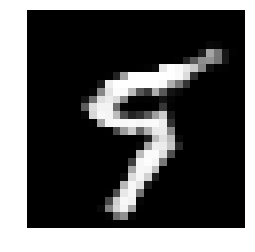

11252 11253 11254 11255 11256 11257 11258 11259 11260 11261 11262 11263 11264 11265 11266 11267 11268 11269 11270 11271 11272 11273 11274 11275 11276 11277 11278 11279 11280 11281 11282 11283 11284 11285 11286 11287 11288 11289 11290 11291 11292 11293 11294 11295 11296 11297 11298 11299 11300 11301 11302 11303 11304 11305 11306 11307 11308 11309 11310 11311 11312 11313 11314 11315 11316 11317 11318 11319 11320 11321 11322 11323 11324 11325 11326 11327 11328 11329 11330 11331 11332 11333 11334 11335 11336 11337 11338 11339 11340 11341 11342 11343 11344 11345 11346 11347 11348 11349 11350 11351 11352 11353 11354 11355 11356 11357 11358 11359 11360 11361 11362 11363 11364 11365 11366 11367 11368 11369 11370 11371 11372 11373 11374 11375 11376 11377 11378 11379 11380 11381 11382 11383 11384 11385 11386 11387 11388 11389 11390 11391 11392 11393 11394 11395 11396 11397 11398 11399 11400 11401 11402 11403 11404 11405 11406 11407 11408 11409 11410 11411 11412 11413 11414 11415 11416 11417 1141

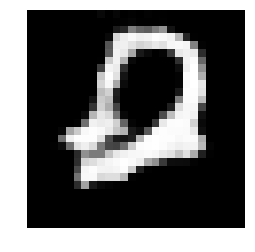

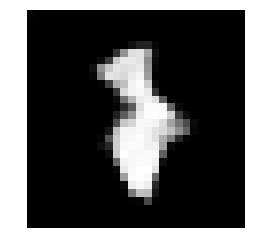

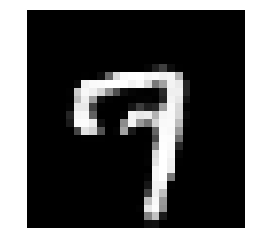

12002 12003 12004 12005 12006 12007 12008 12009 12010 12011 12012 12013 12014 12015 12016 12017 12018 12019 12020 12021 12022 12023 12024 12025 12026 12027 12028 12029 12030 12031 12032 12033 12034 12035 12036 12037 12038 12039 12040 12041 12042 12043 12044 12045 12046 12047 12048 12049 12050 12051 12052 12053 12054 12055 12056 12057 12058 12059 12060 12061 12062 12063 12064 12065 12066 12067 12068 12069 12070 12071 12072 12073 12074 12075 12076 12077 12078 12079 12080 12081 12082 12083 12084 12085 12086 12087 12088 12089 12090 12091 12092 12093 12094 12095 12096 12097 12098 12099 12100 12101 12102 12103 12104 12105 12106 12107 12108 12109 12110 12111 12112 12113 12114 12115 12116 12117 12118 12119 12120 12121 12122 12123 12124 12125 12126 12127 12128 12129 12130 12131 12132 12133 12134 12135 12136 12137 12138 12139 12140 12141 12142 12143 12144 12145 12146 12147 12148 12149 12150 12151 12152 12153 12154 12155 12156 12157 12158 12159 12160 12161 12162 12163 12164 12165 12166 12167 1216

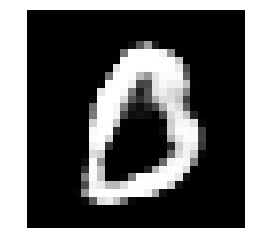

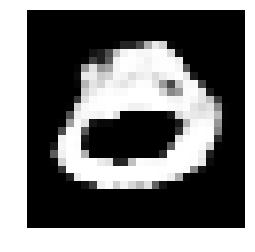

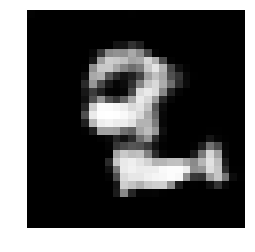

12752 12753 12754 12755 12756 12757 12758 12759 12760 12761 12762 12763 12764 12765 12766 12767 12768 12769 12770 12771 12772 12773 12774 12775 12776 12777 12778 12779 12780 12781 12782 12783 12784 12785 12786 12787 12788 12789 12790 12791 12792 12793 12794 12795 12796 12797 12798 12799 12800 12801 12802 12803 12804 12805 12806 12807 12808 12809 12810 12811 12812 12813 12814 12815 12816 12817 12818 12819 12820 12821 12822 12823 12824 12825 12826 12827 12828 12829 12830 12831 12832 12833 12834 12835 12836 12837 12838 12839 12840 12841 12842 12843 12844 12845 12846 12847 12848 12849 12850 12851 12852 12853 12854 12855 12856 12857 12858 12859 12860 12861 12862 12863 12864 12865 12866 12867 12868 12869 12870 12871 12872 12873 12874 12875 12876 12877 12878 12879 12880 12881 12882 12883 12884 12885 12886 12887 12888 12889 12890 12891 12892 12893 12894 12895 12896 12897 12898 12899 12900 12901 12902 12903 12904 12905 12906 12907 12908 12909 12910 12911 12912 12913 12914 12915 12916 12917 1291

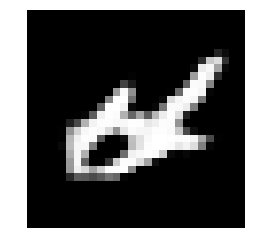

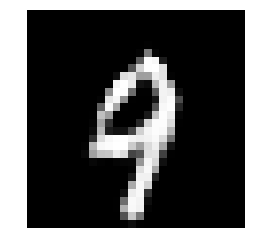

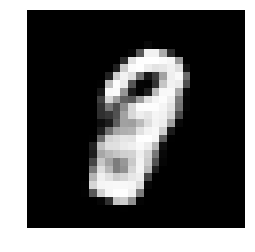

13502 13503 13504 13505 13506 13507 13508 13509 13510 13511 13512 13513 13514 13515 13516 13517 13518 13519 13520 13521 13522 13523 13524 13525 13526 13527 13528 13529 13530 13531 13532 13533 13534 13535 13536 13537 13538 13539 13540 13541 13542 13543 13544 13545 13546 13547 13548 13549 13550 13551 13552 13553 13554 13555 13556 13557 13558 13559 13560 13561 13562 13563 13564 13565 13566 13567 13568 13569 13570 13571 13572 13573 13574 13575 13576 13577 13578 13579 13580 13581 13582 13583 13584 13585 13586 13587 13588 13589 13590 13591 13592 13593 13594 13595 13596 13597 13598 13599 13600 13601 13602 13603 13604 13605 13606 13607 13608 13609 13610 13611 13612 13613 13614 13615 13616 13617 13618 13619 13620 13621 13622 13623 13624 13625 13626 13627 13628 13629 13630 13631 13632 13633 13634 13635 13636 13637 13638 13639 13640 13641 13642 13643 13644 13645 13646 13647 13648 13649 13650 13651 13652 13653 13654 13655 13656 13657 13658 13659 13660 13661 13662 13663 13664 13665 13666 13667 1366

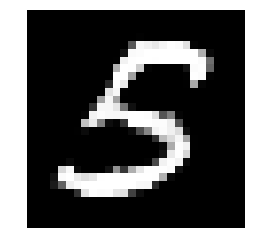

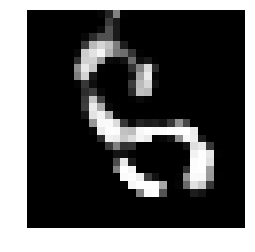

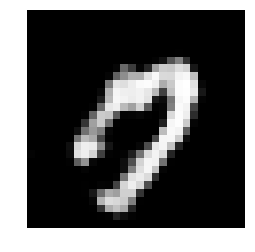

14252 14253 14254 14255 14256 14257 14258 14259 14260 14261 14262 14263 14264 14265 14266 14267 14268 14269 14270 14271 14272 14273 14274 14275 14276 14277 14278 14279 14280 14281 14282 14283 14284 14285 14286 14287 14288 14289 14290 14291 14292 14293 14294 14295 14296 14297 14298 14299 14300 14301 14302 14303 14304 14305 14306 14307 14308 14309 14310 14311 14312 14313 14314 14315 14316 14317 14318 14319 14320 14321 14322 14323 14324 14325 14326 14327 14328 14329 14330 14331 14332 14333 14334 14335 14336 14337 14338 14339 14340 14341 14342 14343 14344 14345 14346 14347 14348 14349 14350 14351 14352 14353 14354 14355 14356 14357 14358 14359 14360 14361 14362 14363 14364 14365 14366 14367 14368 14369 14370 14371 14372 14373 14374 14375 14376 14377 14378 14379 14380 14381 14382 14383 14384 14385 14386 14387 14388 14389 14390 14391 14392 14393 14394 14395 14396 14397 14398 14399 14400 14401 14402 14403 14404 14405 14406 14407 14408 14409 14410 14411 14412 14413 14414 14415 14416 14417 1441

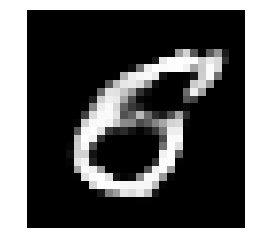

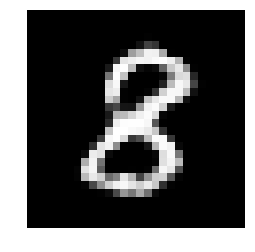

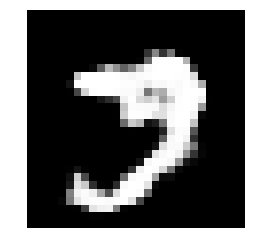

15002 15003 15004 15005 15006 15007 15008 15009 15010 15011 15012 15013 15014 15015 15016 15017 15018 15019 15020 15021 15022 15023 15024 15025 15026 15027 15028 15029 15030 15031 15032 15033 15034 15035 15036 15037 15038 15039 15040 15041 15042 15043 15044 15045 15046 15047 15048 15049 15050 15051 15052 15053 15054 15055 15056 15057 15058 15059 15060 15061 15062 15063 15064 15065 15066 15067 15068 15069 15070 15071 15072 15073 15074 15075 15076 15077 15078 15079 15080 15081 15082 15083 15084 15085 15086 15087 15088 15089 15090 15091 15092 15093 15094 15095 15096 15097 15098 15099 15100 15101 15102 15103 15104 15105 15106 15107 15108 15109 15110 15111 15112 15113 15114 15115 15116 15117 15118 15119 15120 15121 15122 15123 15124 15125 15126 15127 15128 15129 15130 15131 15132 15133 15134 15135 15136 15137 15138 15139 15140 15141 15142 15143 15144 15145 15146 15147 15148 15149 15150 15151 15152 15153 15154 15155 15156 15157 15158 15159 15160 15161 15162 15163 15164 15165 15166 15167 1516

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    G_loss_epoch = 0
    D_loss_epoch = 0
    
    for i in range(1, 20000):
        print(i, end=" ")
        images_set = mnist.train.next_batch(batch_size)[0].reshape(-1, 28, 28, 1)
            
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: images_set, Z: sampling_Z(batch_size, Z_dimension)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sampling_Z(batch_size, Z_dimension)})
        
        G_loss_epoch += G_loss_curr
        D_loss_epoch += D_loss_curr
        
        if i % 750 == 1:
            print('Epoch: {}'.format(i/750))
            print('G_loss: {:.4}'.format(G_loss_epoch/750))
            print('D_loss: {:.4}'.format(D_loss_epoch/750))
                  
            G_loss_epoch = 0
            D_loss_epoch = 0
                  
            samples = sess.run(Generator_sample, feed_dict={Z: sampling_Z(batch_size, Z_dimension)})
            for i in range(3):
                  plot(samples[i])